In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import norm

import requests

In [2]:
from pylab import mpl

# 对中文字体的支持
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
mpl.rcParams['axes.unicode_minus'] = False 

## 1. rawdata

In [4]:
df = pd.read_excel('data/network_paper_rank.xlsx',index_col=0)

In [5]:
df.shape

(28, 5)

In [6]:
df.sample()

,link,title,abstract,doi,year
17,http://www.sciencedirect.com/science/article/a...,Sequential dynamics of complex networks in min...,"Today, based on brain imaging analyses, we can...",10.1016/j.physrep.2020.08.003,2020


## 2.get citation from semantic scholar

In [9]:
def get_full_record(doi,offset=0,limit=1000):
    url = f'https://api.semanticscholar.org/graph/v1/paper/DOI:{doi}'\
            f'/citations?fields=year,citationCount,fieldsOfStudy&offset={offset}&limit={limit}'
    response = requests.get(url)
    rst = response.json()
    while len(response.json()['data'])==1000:
        offset += 1000
        url = f'https://api.semanticscholar.org/graph/v1/paper/DOI:{doi}'\
        f'/citations?fields=year,citationCount,fieldsOfStudy&offset={offset}&limit={limit}'
        response  = requests.get(url)
        rst['data'].extend(response.json()['data'])
    return rst

In [9]:
lyst1 = []
lyst2 = []
for i in range(len(df)):
    doi = df.loc[i,'doi']
    rst = get_full_record(doi)
    #print(f"论文名:{df.loc[i,'title']},被引量{len(rst['data'])}")
    lyst1.append(len(rst['data']))
    lyst2.append(rst)
    
df.loc[:,'citation_ss'] = lyst1
df.loc[:,'citation_per_year'] = lyst2

In [10]:
df.sample()

,link,title,abstract,doi,year,citation_ss,citation_per_year
15,http://www.sciencedirect.com/science/article/a...,The structure and dynamics of multilayer networks,"In the past years, network theory has successf...",10.1016/j.physrep.2014.07.001,2014,60,"{'offset': 0, 'data': [{'citingPaper': {'paper..."


In [8]:
# #an offline version due 2020.03.16
# df = pd.read_json('data/PR_network_science_paper.json',lines=True)

## 3. longterm citation prediction

In [10]:
# fit function

# M measures the average number of references each new paper contains
M = 20
def fi(x):
    return norm.cdf(x)

def func(x,lam,u,sigma):
    return M*(np.exp(lam*fi((np.log(x) - u)/sigma))-1)

def infinite_citation(lam):
    return M*(np.exp(lam) - 1)

In [11]:
df.sample()

,link,title,abstract,doi,year,citation_ss,citation_per_year
9,http://www.sciencedirect.com/science/article/a...,"Complex systems: Features, similarity and conn...",The increasing interest in complex networks re...,10.1016/j.physrep.2020.03.002,2020,24,"{'offset': 0, 'data': [{'citingPaper': {'paper..."


In [12]:
df = df.reset_index(drop=True)
df[['title','year']]

,title,year
0,The Kuramoto model in complex networks,2015
1,Fundamentals of spreading processes in single ...,2018
2,Vital nodes identification in complex networks,2016
3,"Nestedness in complex networks: Observation, e...",2019
4,Network dynamics of coupled oscillators and ph...,2019
5,Networks beyond pairwise interactions: Structu...,2020
6,"Computational network biology: Data, models, a...",2019
7,Ranking in evolving complex networks,2017
8,Community detection in networks: A user guide,2016
9,"Complex systems: Features, similarity and conn...",2020


In [13]:
for idx,row in df.iterrows():
    nums = {}
    for item in  df.loc[idx,'citation_per_year']['data']:
        if item['citingPaper']['year']:
            nums[item['citingPaper']['year']] = nums.setdefault(item['citingPaper']['year'],0) + 1
    
    nums = {k:v for k,v in nums.items() if k >= df.loc[idx,'year']}
    x = np.arange(min(nums),2022)
    y = [nums[l] if l in nums else 0 for l in x]
    
    x = np.arange(1,2022-min(nums)+1)
    y_cumsum = np.cumsum(y)
#     print('title:',df.loc[idx,'title'])
#     print('citation per year:',nums)
#     print('x:',x)
#     print('y:',y)
#     print('y_cumsum:',y_cumsum)
    
    # at least 3 data points needed
    if len(x)>2:
        coes,cov = curve_fit(func,x,y_cumsum)
        #print('lambda,u,sigma:',coes)
        lam = coes[0]
        final = infinite_citation(lam)
        #print('final:',final)
        df.loc[idx,'infinite_citation'] = final
    df.loc[idx,'first_two_year_citation'] = y[0]+y[1]
    #print('\n')

F:\Anaconda\envs\AI\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [14]:
# infinite_citation column added
df.sample()

,link,title,abstract,doi,year,citation_ss,citation_per_year,infinite_citation,first_two_year_citation
3,http://www.sciencedirect.com/science/article/p...,"Nestedness in complex networks: Observation, e...",The observed architecture of ecological and so...,10.1016/j.physrep.2019.04.001,2019,64,"{'offset': 0, 'data': [{'citingPaper': {'paper...",100.121944,31.0


In [15]:
# paper with num of data points < 3
ratio = 0
i = 0
for idx,row in df.iterrows():
    if not np.isnan(row['infinite_citation']):
        ratio += row['infinite_citation']/row['first_two_year_citation']
        i += 1
        
ave_ratio =  ratio/i

for idx,row in df.iterrows():
    if np.isnan(row['infinite_citation']):
        df.loc[idx,'infinite_citation'] = df.loc[idx,'first_two_year_citation']*ave_ratio

In [63]:
df[['title','year','infinite_citation']].to_csv('rst.csv',index=0,encoding='utf-8')

## 4. case 

In [67]:
def plot_longterm_citation(x,y,func,coes):
    X = np.arange(1,50)
    plt.figure(figsize=(9,6))
    plt.plot(x,y,'*',label='record')
    plt.plot(X,func(X,coes[0],coes[1],coes[2]),alpha=0.5,label='predict')
    plt.xlabel('year',fontsize=15)
    plt.ylabel('citation',fontsize=15)
    plt.legend(fontsize=15)
    return 

title: Random walks and diffusion on networks
lambda,mu,sigma: [3.78575064 0.93611564 0.91744462]


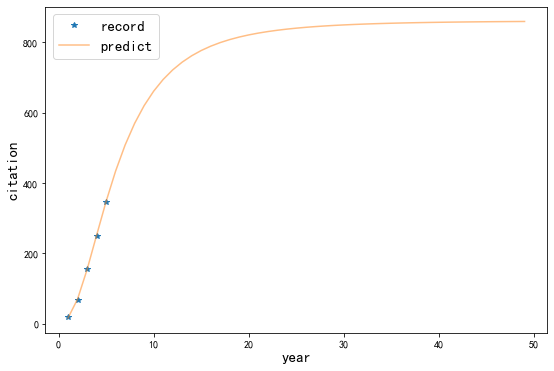

In [71]:
idx = 24
nums = {}
for item in  df.loc[idx,'citation_per_year']['data']:
    if item['citingPaper']['year']:
        nums[item['citingPaper']['year']] = nums.setdefault(item['citingPaper']['year'],0) + 1

nums = {k:v for k,v in nums.items() if k >= df.loc[idx,'year']}
x = np.arange(min(nums),2022)
y = [nums[l] if l in nums else 0 for l in x]

x = np.arange(1,2022-min(nums)+1)
y_cumsum = np.cumsum(y)

coes,cov = curve_fit(func,x,y_cumsum)
print('title:',df.loc[idx,'title'])
print("lambda,mu,sigma:",coes)

plot_longterm_citation(x,y_cumsum,func,coes)

title: The physics of communicability in complex networks
lambda,mu,sigma: [3.75086062 1.66099763 1.43512322]


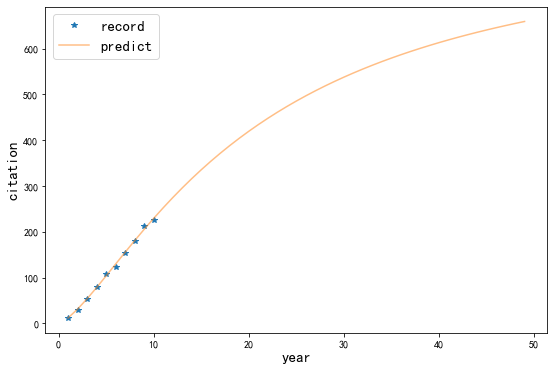

In [85]:
# case: longterm citaion is much greater than current citation
idx = 12
nums = {}
for item in  df.loc[idx,'citation_per_year']['data']:
    if item['citingPaper']['year']:
        nums[item['citingPaper']['year']] = nums.setdefault(item['citingPaper']['year'],0) + 1

nums = {k:v for k,v in nums.items() if k >= df.loc[idx,'year']}
x = np.arange(min(nums),2022)
y = [nums[l] if l in nums else 0 for l in x]

x = np.arange(1,2022-min(nums)+1)
y_cumsum = np.cumsum(y)

coes,cov = curve_fit(func,x,y_cumsum)
print('title:',df.loc[idx,'title'])
print("lambda,mu,sigma:",coes)

plot_longterm_citation(x,y_cumsum,func,coes)

F:\Anaconda\envs\AI\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


title: Complex network approaches to nonlinear time series analysis
lambda,mu,sigma: [1.89711999 0.41653215 0.037221  ]
cov: [[inf inf inf]
 [inf inf inf]
 [inf inf inf]]


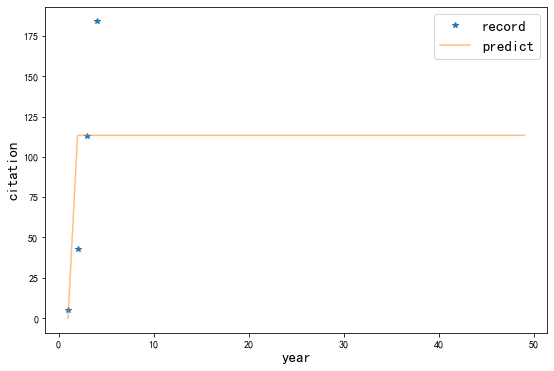

In [89]:
# in a few cases,scipy can not fit data well
# example as below, notice the warnings and cov matrix
# some other tool may help, see in longterm_citation_wl.ipynb

idx = 13
nums = {}
for item in  df.loc[idx,'citation_per_year']['data']:
    if item['citingPaper']['year']:
        nums[item['citingPaper']['year']] = nums.setdefault(item['citingPaper']['year'],0) + 1

nums = {k:v for k,v in nums.items() if k >= df.loc[idx,'year']}
x = np.arange(min(nums),2022)
y = [nums[l] if l in nums else 0 for l in x]

x = np.arange(1,2022-min(nums)+1)
y_cumsum = np.cumsum(y)

coes,cov = curve_fit(func,x,y_cumsum)
print('title:',df.loc[idx,'title'])
print("lambda,mu,sigma:",coes)
print('cov:',cov)

plot_longterm_citation(x,y_cumsum,func,coes)